In [1]:
import pandas as pd
import numpy as np
import feast
import matplotlib.pyplot as plt
import matplotlib

from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn import preprocessing

import shap
import lime
import json
shap.initjs()

from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns

from pprint import pprint
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(matplotlib.__version__)

/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/tpot/base.py:31: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/tpot/builtins/one_hot_encoder.py:216: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, categorical_features='auto', dtype=np.float,
/opt/homebrew/Caskroom/miniforge/base/envs/env_tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/sta

1.5.2
3.2.2


In [2]:
data = pd.read_parquet('feature_repo/raw_data/loan_table.parquet')
data.head(5)

,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,event_timestamp,created_timestamp
0,10000,19530219_5179,76104,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,2021-08-25 20:34:41.361000+00:00,2021-08-25 20:34:41.361000+00:00
1,10001,19520816_8737,70380,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,2021-08-25 20:16:20.128000+00:00,2021-08-25 20:16:20.128000+00:00
2,10002,19860413_2537,97039,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,2021-08-25 19:57:58.896000+00:00,2021-08-25 19:57:58.896000+00:00
3,10003,19760701_8090,63785,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,2021-08-25 19:39:37.663000+00:00,2021-08-25 19:39:37.663000+00:00
4,10004,19830125_8297,82223,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,2021-08-25 19:21:16.430000+00:00,2021-08-25 19:21:16.430000+00:00


In [3]:
data.tail(5)

,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,event_timestamp,created_timestamp
28633,38633,19491126_1487,43205,57,53000,MORTGAGE,1.0,PERSONAL,5800,13.16,0,2020-08-25 21:48:06.292000+00:00,2020-08-25 21:48:06.292000+00:00
28634,38634,19681208_6537,24872,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0,2020-08-25 21:29:45.059000+00:00,2020-08-25 21:29:45.059000+00:00
28635,38635,19880422_2592,68826,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,1,2020-08-25 21:11:23.826000+00:00,2020-08-25 21:11:23.826000+00:00
28636,38636,19901017_6108,92014,56,150000,MORTGAGE,5.0,PERSONAL,15000,11.48,0,2020-08-25 20:53:02.594000+00:00,2020-08-25 20:53:02.594000+00:00
28637,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,6475,9.99,0,2020-08-25 20:34:41.361000+00:00,2020-08-25 20:34:41.361000+00:00


In [4]:
def categorical_encoder(df):
    columns_to_encode = list(df.select_dtypes(include=['category','object']))
    le = preprocessing.LabelEncoder()
    for feature in columns_to_encode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

In [5]:
data.dtypes

loan_id                                int64
dob_ssn                               object
zipcode                                int64
person_age                             int64
person_income                          int64
person_home_ownership                 object
person_emp_length                    float64
loan_intent                           object
loan_amnt                              int64
loan_int_rate                        float64
loan_status                            int64
event_timestamp          datetime64[ns, UTC]
created_timestamp        datetime64[ns, UTC]
dtype: object

In [6]:
data = data.sort_values(by='event_timestamp')
data.head(5)

,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,event_timestamp,created_timestamp
28637,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,6475,9.99,0,2020-08-25 20:34:41.361000+00:00,2020-08-25 20:34:41.361000+00:00
28636,38636,19901017_6108,92014,56,150000,MORTGAGE,5.0,PERSONAL,15000,11.48,0,2020-08-25 20:53:02.594000+00:00,2020-08-25 20:53:02.594000+00:00
28635,38635,19880422_2592,68826,65,76000,RENT,3.0,HOMEIMPROVEMENT,35000,10.99,1,2020-08-25 21:11:23.826000+00:00,2020-08-25 21:11:23.826000+00:00
28634,38634,19681208_6537,24872,54,120000,MORTGAGE,4.0,PERSONAL,17625,7.49,0,2020-08-25 21:29:45.059000+00:00,2020-08-25 21:29:45.059000+00:00
28633,38633,19491126_1487,43205,57,53000,MORTGAGE,1.0,PERSONAL,5800,13.16,0,2020-08-25 21:48:06.292000+00:00,2020-08-25 21:48:06.292000+00:00


In [7]:
data.tail(5)

,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,event_timestamp,created_timestamp
4,10004,19830125_8297,82223,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,2021-08-25 19:21:16.430000+00:00,2021-08-25 19:21:16.430000+00:00
3,10003,19760701_8090,63785,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,2021-08-25 19:39:37.663000+00:00,2021-08-25 19:39:37.663000+00:00
2,10002,19860413_2537,97039,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,2021-08-25 19:57:58.896000+00:00,2021-08-25 19:57:58.896000+00:00
1,10001,19520816_8737,70380,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,2021-08-25 20:16:20.128000+00:00,2021-08-25 20:16:20.128000+00:00
0,10000,19530219_5179,76104,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,2021-08-25 20:34:41.361000+00:00,2021-08-25 20:34:41.361000+00:00


In [8]:
print('Min timestamp:', data['event_timestamp'].min())
print('Max timestamp:', data['event_timestamp'].max())

Min timestamp: 2020-08-25 20:34:41.361000+00:00
Max timestamp: 2021-08-25 20:34:41.361000+00:00


In [9]:
print('Lengh of Unique dob_ssn:', len(list(data['dob_ssn'].unique())))
print('Lengh of Unique zipcode:', len(list(data['zipcode'].unique())))

Lengh of Unique dob_ssn: 28633
Lengh of Unique zipcode: 18050


In [10]:
fs = feast.FeatureStore(repo_path='feature_repo/')
feature_service_v1 = fs.get_feature_service("features_group_v1")
feature_service_v2 = fs.get_feature_service("features_group_v2")

In [11]:
training_df = fs.get_historical_features(
    entity_df=data,
    features=feature_service_v1
).to_df()

In [12]:
training_df.head(5)

,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,...,missed_payments_2y,missed_payments_1y,missed_payments_6m,bankruptcies,city,state,location_type,tax_returns_filed,population,total_wages
0,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,6475,9.99,...,4,0,1,0,IMPERIAL,NE,PRIMARY,1171,2141,32596076
1,38276,19770128_3701,61345,39,75000,RENT,0.0,PERSONAL,14400,12.53,...,6,1,0,0,NEPONSET,IL,PRIMARY,413,730,11569469
2,38287,19600201_7821,54901,48,140000,MORTGAGE,4.0,EDUCATION,18000,9.99,...,1,0,0,0,OSHKOSH,WI,PRIMARY,15059,23996,469695341
3,38286,19921119_7451,20912,36,58000,RENT,18.0,DEBTCONSOLIDATION,5000,6.62,...,0,0,0,0,TAKOMA PARK,MD,PRIMARY,11982,19175,543954725
4,38285,19580615_7535,64856,46,48956,RENT,0.0,MEDICAL,2800,10.59,...,1,1,0,1,PINEVILLE,MO,PRIMARY,1609,2929,45969820


In [13]:
list(training_df.columns)

['loan_id',
 'dob_ssn',
 'zipcode',
 'person_age',
 'person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'event_timestamp',
 'created_timestamp__',
 'credit_card_due',
 'mortgage_due',
 'student_loan_due',
 'vehicle_loan_due',
 'hard_pulls',
 'missed_payments_2y',
 'missed_payments_1y',
 'missed_payments_6m',
 'bankruptcies',
 'city',
 'state',
 'location_type',
 'tax_returns_filed',
 'population',
 'total_wages']

In [14]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28638 entries, 0 to 28637
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   loan_id                28638 non-null  int64              
 1   dob_ssn                28638 non-null  object             
 2   zipcode                28638 non-null  int64              
 3   person_age             28638 non-null  int64              
 4   person_income          28638 non-null  int64              
 5   person_home_ownership  28638 non-null  object             
 6   person_emp_length      28638 non-null  float64            
 7   loan_intent            28638 non-null  object             
 8   loan_amnt              28638 non-null  int64              
 9   loan_int_rate          28638 non-null  float64            
 10  loan_status            28638 non-null  int64              
 11  event_timestamp        28638 non-null  datetime64[ns, 

In [15]:
training_dtypes = pd.DataFrame({
    "types": training_df.dtypes
})
training_dtypes['col'] = training_dtypes.index
training_dtypes.set_index(['types', 'col'], inplace=True)
# training_dtypes.sort_index(inplace=True)

In [16]:
training_dtypes

Empty DataFrame
Columns: []
Index: [(int64, loan_id), (object, dob_ssn), (int64, zipcode), (int64, person_age), (int64, person_income), (object, person_home_ownership), (float64, person_emp_length), (object, loan_intent), (int64, loan_amnt), (float64, loan_int_rate), (int64, loan_status), (datetime64[ns, UTC], event_timestamp), (datetime64[ns], created_timestamp__), (int64, credit_card_due), (int64, mortgage_due), (int64, student_loan_due), (int64, vehicle_loan_due), (int64, hard_pulls), (int64, missed_payments_2y), (int64, missed_payments_1y), (int64, missed_payments_6m), (int64, bankruptcies), (object, city), (object, state), (object, location_type), (int64, tax_returns_filed), (int64, population), (int64, total_wages)]

In [17]:
df = training_df.sort_values(['event_timestamp'])
new_cols = list(training_df.columns)
new_cols.remove('event_timestamp')
new_cols.remove('created_timestamp__')
new_cols = ['event_timestamp', 'created_timestamp__'] + new_cols
df = df[new_cols]
df.head(5)

,event_timestamp,created_timestamp__,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,...,missed_payments_2y,missed_payments_1y,missed_payments_6m,bankruptcies,city,state,location_type,tax_returns_filed,population,total_wages
0,2020-08-25 20:34:41.361000+00:00,2020-08-23 18:01:04.746575,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,...,4,0,1,0,IMPERIAL,NE,PRIMARY,1171,2141,32596076
198,2020-08-25 20:53:02.594000+00:00,2020-08-23 18:01:04.746575,38636,19901017_6108,92014,56,150000,MORTGAGE,5.0,PERSONAL,...,1,0,0,0,DEL MAR,CA,PRIMARY,7681,12635,653566215
199,2020-08-25 21:11:23.826000+00:00,2020-08-23 18:01:04.746575,38635,19880422_2592,68826,65,76000,RENT,3.0,HOMEIMPROVEMENT,...,7,0,0,0,CENTRAL CITY,NE,PRIMARY,1746,3147,47886607
200,2020-08-25 21:29:45.059000+00:00,2020-08-23 18:01:04.746575,38634,19681208_6537,24872,54,120000,MORTGAGE,4.0,PERSONAL,...,1,0,0,0,PANTHER,WV,PRIMARY,252,518,7205163
201,2020-08-25 21:48:06.292000+00:00,2020-08-23 18:01:04.746575,38633,19491126_1487,43205,57,53000,MORTGAGE,1.0,PERSONAL,...,4,0,1,0,COLUMBUS,OH,PRIMARY,4826,7185,112085573


In [18]:
df['loan_status']

0        0
198      0
199      1
200      0
201      0
        ..
28565    1
28555    1
28434    1
28428    0
28437    1
Name: loan_status, Length: 28638, dtype: int64

In [19]:
df

,event_timestamp,created_timestamp__,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,...,missed_payments_2y,missed_payments_1y,missed_payments_6m,bankruptcies,city,state,location_type,tax_returns_filed,population,total_wages
0,2020-08-25 20:34:41.361000+00:00,2020-08-23 18:01:04.746575,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,...,4,0,1,0,IMPERIAL,NE,PRIMARY,1171,2141,32596076
198,2020-08-25 20:53:02.594000+00:00,2020-08-23 18:01:04.746575,38636,19901017_6108,92014,56,150000,MORTGAGE,5.0,PERSONAL,...,1,0,0,0,DEL MAR,CA,PRIMARY,7681,12635,653566215
199,2020-08-25 21:11:23.826000+00:00,2020-08-23 18:01:04.746575,38635,19880422_2592,68826,65,76000,RENT,3.0,HOMEIMPROVEMENT,...,7,0,0,0,CENTRAL CITY,NE,PRIMARY,1746,3147,47886607
200,2020-08-25 21:29:45.059000+00:00,2020-08-23 18:01:04.746575,38634,19681208_6537,24872,54,120000,MORTGAGE,4.0,PERSONAL,...,1,0,0,0,PANTHER,WV,PRIMARY,252,518,7205163
201,2020-08-25 21:48:06.292000+00:00,2020-08-23 18:01:04.746575,38633,19491126_1487,43205,57,53000,MORTGAGE,1.0,PERSONAL,...,4,0,1,0,COLUMBUS,OH,PRIMARY,4826,7185,112085573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28565,2021-08-25 19:21:16.430000+00:00,2021-08-22 18:01:04.746575,10004,19830125_8297,82223,24,54400,RENT,8.0,MEDICAL,...,6,0,1,0,LINGLE,WY,PRIMARY,462,857,13324885
28555,2021-08-25 19:39:37.663000+00:00,2021-08-22 18:01:04.746575,10003,19760701_8090,63785,23,65500,RENT,4.0,MEDICAL,...,4,0,0,0,WHITEWATER,MO,PRIMARY,441,863,14308153
28434,2021-08-25 19:57:58.896000+00:00,2021-08-22 18:01:04.746575,10002,19860413_2537,97039,25,9600,MORTGAGE,1.0,MEDICAL,...,7,1,1,0,MORO,OR,PRIMARY,253,420,5495473
28428,2021-08-25 20:16:20.128000+00:00,2021-08-22 18:01:04.746575,10001,19520816_8737,70380,21,9600,OWN,5.0,EDUCATION,...,5,1,1,0,MORGAN CITY,LA,PRIMARY,8200,14869,295677025


In [20]:
df['loan_intent_home'] = df['loan_intent'] + '_'+ df['person_home_ownership']

In [21]:
df

,event_timestamp,created_timestamp__,loan_id,dob_ssn,zipcode,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,...,missed_payments_1y,missed_payments_6m,bankruptcies,city,state,location_type,tax_returns_filed,population,total_wages,loan_intent_home
0,2020-08-25 20:34:41.361000+00:00,2020-08-23 18:01:04.746575,38637,19960703_3449,69033,66,42000,RENT,2.0,MEDICAL,...,0,1,0,IMPERIAL,NE,PRIMARY,1171,2141,32596076,MEDICAL_RENT
198,2020-08-25 20:53:02.594000+00:00,2020-08-23 18:01:04.746575,38636,19901017_6108,92014,56,150000,MORTGAGE,5.0,PERSONAL,...,0,0,0,DEL MAR,CA,PRIMARY,7681,12635,653566215,PERSONAL_MORTGAGE
199,2020-08-25 21:11:23.826000+00:00,2020-08-23 18:01:04.746575,38635,19880422_2592,68826,65,76000,RENT,3.0,HOMEIMPROVEMENT,...,0,0,0,CENTRAL CITY,NE,PRIMARY,1746,3147,47886607,HOMEIMPROVEMENT_RENT
200,2020-08-25 21:29:45.059000+00:00,2020-08-23 18:01:04.746575,38634,19681208_6537,24872,54,120000,MORTGAGE,4.0,PERSONAL,...,0,0,0,PANTHER,WV,PRIMARY,252,518,7205163,PERSONAL_MORTGAGE
201,2020-08-25 21:48:06.292000+00:00,2020-08-23 18:01:04.746575,38633,19491126_1487,43205,57,53000,MORTGAGE,1.0,PERSONAL,...,0,1,0,COLUMBUS,OH,PRIMARY,4826,7185,112085573,PERSONAL_MORTGAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28565,2021-08-25 19:21:16.430000+00:00,2021-08-22 18:01:04.746575,10004,19830125_8297,82223,24,54400,RENT,8.0,MEDICAL,...,0,1,0,LINGLE,WY,PRIMARY,462,857,13324885,MEDICAL_RENT
28555,2021-08-25 19:39:37.663000+00:00,2021-08-22 18:01:04.746575,10003,19760701_8090,63785,23,65500,RENT,4.0,MEDICAL,...,0,0,0,WHITEWATER,MO,PRIMARY,441,863,14308153,MEDICAL_RENT
28434,2021-08-25 19:57:58.896000+00:00,2021-08-22 18:01:04.746575,10002,19860413_2537,97039,25,9600,MORTGAGE,1.0,MEDICAL,...,1,1,0,MORO,OR,PRIMARY,253,420,5495473,MEDICAL_MORTGAGE
28428,2021-08-25 20:16:20.128000+00:00,2021-08-22 18:01:04.746575,10001,19520816_8737,70380,21,9600,OWN,5.0,EDUCATION,...,1,1,0,MORGAN CITY,LA,PRIMARY,8200,14869,295677025,EDUCATION_OWN


## Baseline models:
Some feature engineering...

In [75]:
df['real_age'] = pd.DatetimeIndex(
    df['event_timestamp']).year - df['dob_ssn'].apply(lambda x: int(x[:4]))

In [76]:
df['real_age_equal_person']  = df.apply(lambda x: 1 if x['real_age'] == x['person_age'] else 0, axis=1)

In [77]:
# remove only identiy columns
remove_list = ['event_timestamp', 'created_timestamp__', 'loan_id', 'dob_ssn', 'zipcode']
target_cols = ['loan_status']
features_set_v1 = list(set(df.columns) - set(remove_list) - set(target_cols))
# remove wrong age
features_set_v1.remove('person_age')
# remove some other features
features_set_v1.remove('state')
features_set_v1.remove('real_age_equal_person')
features_set_v1.remove('loan_intent_home')
features_set_v1.remove('real_age')

features_set_v1.sort()
features_set_v1

['bankruptcies',
 'city',
 'credit_card_due',
 'hard_pulls',
 'loan_amnt',
 'loan_int_rate',
 'loan_intent',
 'location_type',
 'missed_payments_1y',
 'missed_payments_2y',
 'missed_payments_6m',
 'mortgage_due',
 'person_emp_length',
 'person_home_ownership',
 'person_income',
 'population',
 'student_loan_due',
 'tax_returns_filed',
 'total_wages',
 'vehicle_loan_due']

In [78]:
dataset_v1 = df[features_set_v1]

dataset_v1 = categorical_encoder(dataset_v1)
print(list(dataset_v1.columns))
dataset_v1

['bankruptcies', 'city', 'credit_card_due', 'hard_pulls', 'loan_amnt', 'loan_int_rate', 'loan_intent', 'location_type', 'missed_payments_1y', 'missed_payments_2y', 'missed_payments_6m', 'mortgage_due', 'person_emp_length', 'person_home_ownership', 'person_income', 'population', 'student_loan_due', 'tax_returns_filed', 'total_wages', 'vehicle_loan_due']


,bankruptcies,city,credit_card_due,hard_pulls,loan_amnt,loan_int_rate,loan_intent,location_type,missed_payments_1y,missed_payments_2y,missed_payments_6m,mortgage_due,person_emp_length,person_home_ownership,person_income,population,student_loan_due,tax_returns_filed,total_wages,vehicle_loan_due
0,0,4187,1928,1,6475,9.99,3,0,0,4,1,1197324,2.0,3,42000,2141,24208,1171,32596076,4691
198,0,2185,1257,1,15000,11.48,4,0,0,1,0,152136,5.0,0,150000,12635,42087,7681,653566215,26234
199,0,1468,4089,3,35000,10.99,2,0,0,7,0,1384134,3.0,3,76000,3147,31368,1746,47886607,28279
200,0,6699,7580,0,17625,7.49,4,0,0,1,0,1489350,4.0,0,120000,518,36038,252,7205163,6894
201,0,1801,388,6,5800,13.16,4,0,0,4,1,438726,1.0,0,53000,7185,41429,4826,112085573,12736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28565,0,4951,9294,10,35000,14.27,3,0,0,6,1,1485576,8.0,3,54400,857,16009,462,13324885,11457
28555,0,9606,2345,8,35000,15.23,3,0,0,4,0,1619904,4.0,3,65500,863,1429,441,14308153,20339
28434,0,5831,5508,1,5500,12.87,3,0,1,7,1,1010133,1.0,0,9600,420,8533,253,5495473,16130
28428,0,5819,3308,6,1000,11.14,1,0,1,5,1,1181555,5.0,2,9600,14869,39015,8200,295677025,19073


In [79]:
# dataset_v1['amount_over_income'] = \
#     dataset_v1['loan_amnt'] * (1 + dataset_v1['loan_int_rate']) / dataset_v1['person_income']
dataset_v1['amount_over_income2'] = \
    dataset_v1['loan_amnt'] / dataset_v1['person_income']

dataset_v1['missed'] = \
    dataset_v1['missed_payments_1y'] * 2 + dataset_v1['missed_payments_2y'] + dataset_v1['missed_payments_6m'] * 3
# dataset_v1['missed2'] = \
#     dataset_v1['missed_payments_1y'] + dataset_v1['missed_payments_2y'] + dataset_v1['missed_payments_6m']
dataset_v1['all_income'] = dataset_v1['person_income'] * dataset_v1['person_emp_length']
del dataset_v1['person_emp_length']
# del dataset_v1['person_income']


dataset_v1['all_due'] = \
    dataset_v1['credit_card_due'] + dataset_v1['student_loan_due'] + dataset_v1['vehicle_loan_due'] 

# dataset_v1['all_income_sub_due'] = dataset_v1['all_income'] - dataset_v1['all_due']
# dataset_v1['all_income_over_due'] = np.log(dataset_v1['all_income']+1) - np.log(dataset_v1['all_due']+1)
# dataset_v1['due_over_all_incomde'] = np.log(dataset_v1['all_due']+1) - np.log(dataset_v1['all_income']+1)

# dataset_v1['amount_over_all'] = \
#     np.log(dataset_v1['loan_amnt']+1) - np.log(dataset_v1['all_income']+1)

# dataset_v1['loan_after_rets'] = dataset_v1['loan_amnt'] * (1 + dataset_v1['loan_int_rate']/100)
# dataset_v1['all_income_sub_due2'] = \
#     np.log(dataset_v1['all_income']+1) - np.log(dataset_v1['all_due']+1) - np.log(dataset_v1['loan_after_rets']+1)
# dataset_v1['loan_after_rets_over_income'] = np.log(dataset_v1['loan_after_rets']) - np.log(dataset_v1['all_income']+1)
# del dataset_v1['loan_amnt']
# del dataset_v1['loan_after_rets']

del dataset_v1['missed_payments_2y']
del dataset_v1['missed_payments_1y']
del dataset_v1['missed_payments_6m']
del dataset_v1['city']
del dataset_v1['credit_card_due']
del dataset_v1['student_loan_due']
del dataset_v1['total_wages']
del dataset_v1['location_type']
del dataset_v1['vehicle_loan_due']
del dataset_v1['all_due']
del dataset_v1['tax_returns_filed']
del dataset_v1['population']
del dataset_v1['loan_amnt']
del dataset_v1['mortgage_due']
# del dataset_v1['state']
# del dataset_v1['person_income']

In [80]:
dataset_v1

,bankruptcies,hard_pulls,loan_int_rate,loan_intent,person_home_ownership,person_income,amount_over_income2,missed,all_income
0,0,1,9.99,3,3,42000,0.154167,7,84000.0
198,0,1,11.48,4,0,150000,0.100000,1,750000.0
199,0,3,10.99,2,3,76000,0.460526,7,228000.0
200,0,0,7.49,4,0,120000,0.146875,1,480000.0
201,0,6,13.16,4,0,53000,0.109434,7,53000.0
...,...,...,...,...,...,...,...,...,...
28565,0,10,14.27,3,3,54400,0.643382,9,435200.0
28555,0,8,15.23,3,3,65500,0.534351,4,262000.0
28434,0,1,12.87,3,0,9600,0.572917,12,9600.0
28428,0,6,11.14,1,2,9600,0.104167,10,48000.0


In [81]:
[c for c in list(dataset_v1.columns) if 'due' in c]

[]

In [82]:
target = np.ravel(df[target_cols])
target

array([0, 0, 1, ..., 1, 0, 1])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_v1, target,
    train_size=0.75, 
    test_size=0.25,
    shuffle=False)

In [84]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21478, 9) (21478,)
(7160, 9) (7160,)


In [85]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)
print(sample_weights)

# xgb_classifier.fit(X, y, sample_weight=sample_weights)

[0.62793825 0.62793825 2.45406764 ... 0.62793825 0.62793825 0.62793825]


In [86]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# Average CV score on the training set was: 0.9553601643646698
exported_pipeline = xgboost.XGBClassifier(
        learning_rate=0.1, 
        max_depth=10, 
        min_child_weight=5, 
        n_estimators=100, 
        nthread=1,
        subsample=1.0)
exported_pipeline.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=1, num_parallel_tree=None,
              predictor=None, ...)

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5333
           1       0.79      0.84      0.81      1827

    accuracy                           0.90      7160
   macro avg       0.86      0.88      0.87      7160
weighted avg       0.90      0.90      0.90      7160

ROC-AUC: 0.8795368573425822


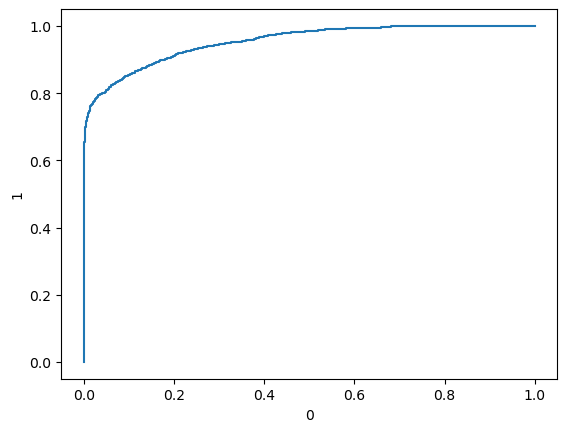

In [87]:
y_pred = exported_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

#define metrics
y_pred_proba = exported_pipeline.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel(1)
plt.xlabel(0)
plt.show()

In [88]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(exported_pipeline, random_state=2).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist(), top=30)

Weight,Feature
0.1137 ± 0.0034,all_income
0.0946 ± 0.0036,amount_over_income2
0.0860 ± 0.0073,loan_int_rate
0.0832 ± 0.0027,missed
0.0512 ± 0.0061,person_income
0.0459 ± 0.0045,bankruptcies
0.0442 ± 0.0060,person_home_ownership
0.0440 ± 0.0039,hard_pulls
0.0260 ± 0.0035,loan_intent


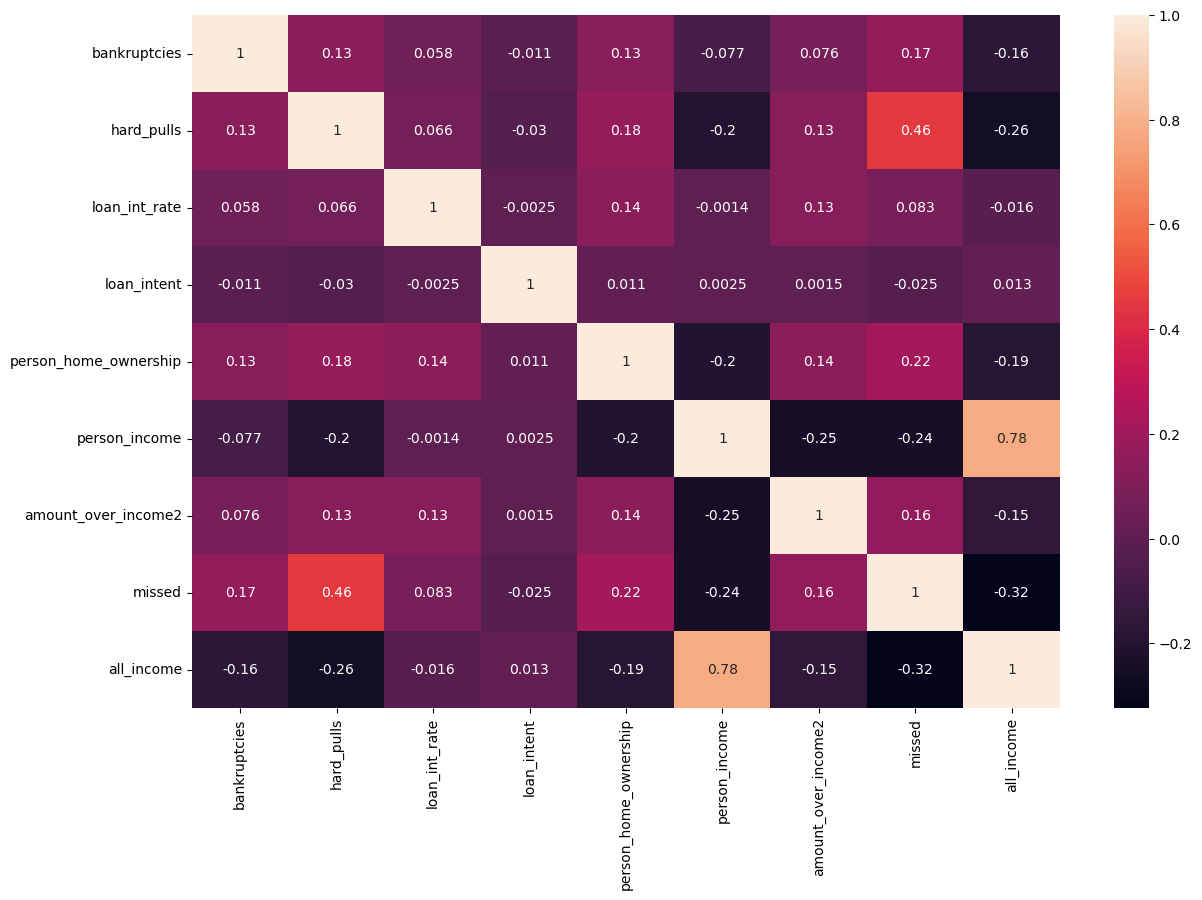

In [89]:
corr = dataset_v1.corr()
plt.figure(figsize=(14, 9))
sns.heatmap(corr, annot=True)
plt.show()

## Analyze False Positive sample from Baseline:
- Sample all FP value in test dataset.
- Calculate SHAP values.
- Plot and find issues from features.
- Repeat feature engineering process.

In [90]:
fp_idx = []
fp_idx = [i for i, (y_hat, y) in enumerate(zip(y_pred, y_test)) if y_hat == 0 and y == 1]

X_sample = X_test.iloc[fp_idx]
y_sample_prob = exported_pipeline.predict_proba(X_sample)
X_sample, y_sample_prob = shuffle(X_sample, y_sample_prob, random_state=1)


explainer = shap.TreeExplainer(exported_pipeline)
shap_values = explainer.shap_values(X_sample)

[0.51360404 0.48639593]
{'all_income': 216000.0,
 'amount_over_income2': 0.1111111111,
 'bankruptcies': 0.0,
 'hard_pulls': 0.0,
 'loan_int_rate': 12.69,
 'loan_intent': 0.0,
 'missed': 6.0,
 'person_home_ownership': 0.0,
 'person_income': 36000.0}


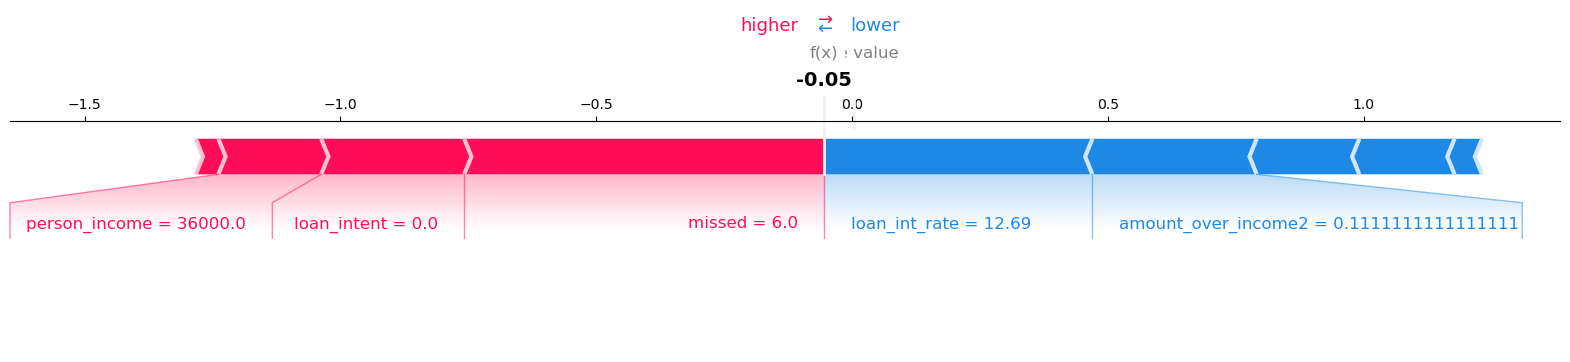

In [91]:
idx = 0
print(y_sample_prob[idx]) # print prob from baseline
pprint(json.loads(X_sample.iloc[idx,:].to_json()))
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_sample.iloc[idx,:],
    matplotlib=True
)

[0.63434017 0.36565983]
{'all_income': 90000.0,
 'amount_over_income2': 0.0833333333,
 'bankruptcies': 0.0,
 'hard_pulls': 8.0,
 'loan_int_rate': 7.14,
 'loan_intent': 0.0,
 'missed': 3.0,
 'person_home_ownership': 3.0,
 'person_income': 30000.0}


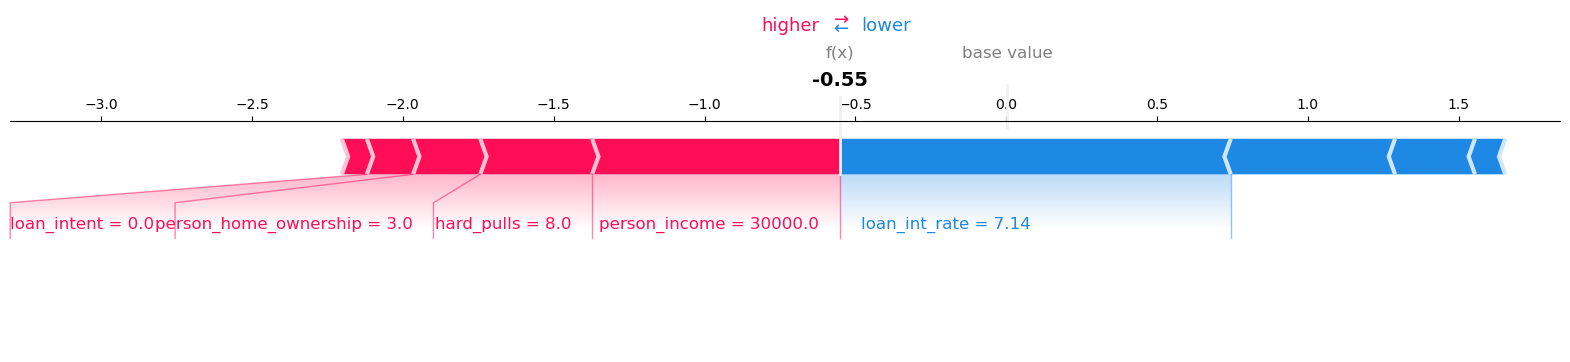

In [92]:
idx = 1
print(y_sample_prob[idx])
pprint(json.loads(X_sample.iloc[idx,:].to_json()))
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_sample.iloc[idx,:],
    matplotlib=True
)

[0.90020347 0.09979653]
{'all_income': 153000.0,
 'amount_over_all': -2.5454544777,
 'amount_over_income2': 0.2352941176,
 'bankruptcies': 0.0,
 'hard_pulls': 7.0,
 'loan_amnt': 12000.0,
 'loan_int_rate': 7.88,
 'loan_intent': 4.0,
 'missed': 15.0,
 'mortgage_due': 317394.0,
 'person_home_ownership': 3.0,
 'person_income': 51000.0,
 'real_age': 56.0}


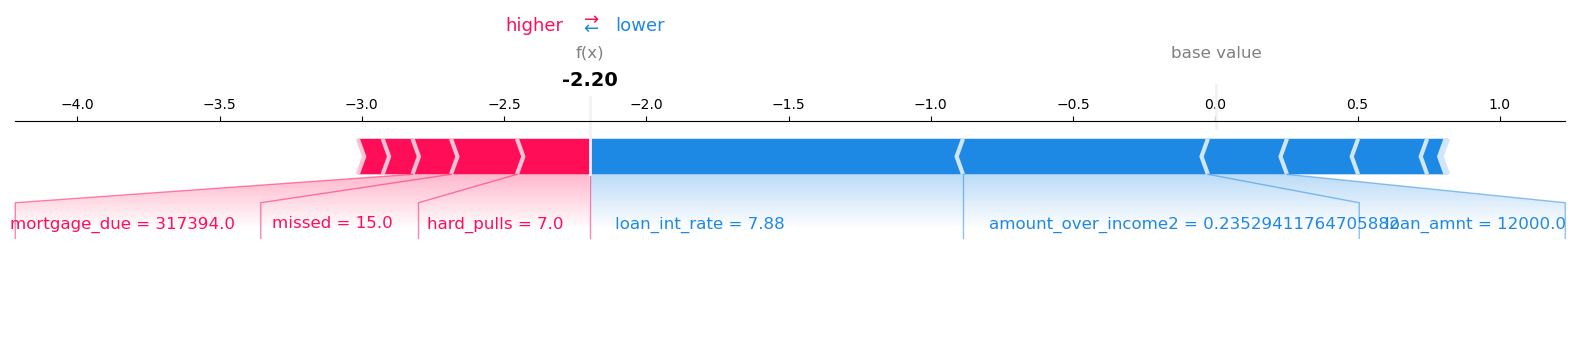

In [41]:
idx = 2
print(y_sample_prob[idx])
pprint(json.loads(X_sample.iloc[idx,:].to_json()))
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_sample.iloc[idx,:],
    matplotlib=True
)

[0.5938666  0.40613344]
{'all_income': 97200.0,
 'amount_over_all': -4.0165939462,
 'amount_over_income2': 0.0540123457,
 'bankruptcies': 0.0,
 'hard_pulls': 0.0,
 'loan_amnt': 1750.0,
 'loan_int_rate': 13.61,
 'loan_intent': 4.0,
 'missed': 10.0,
 'mortgage_due': 764415.0,
 'person_home_ownership': 0.0,
 'person_income': 32400.0,
 'real_age': 43.0}


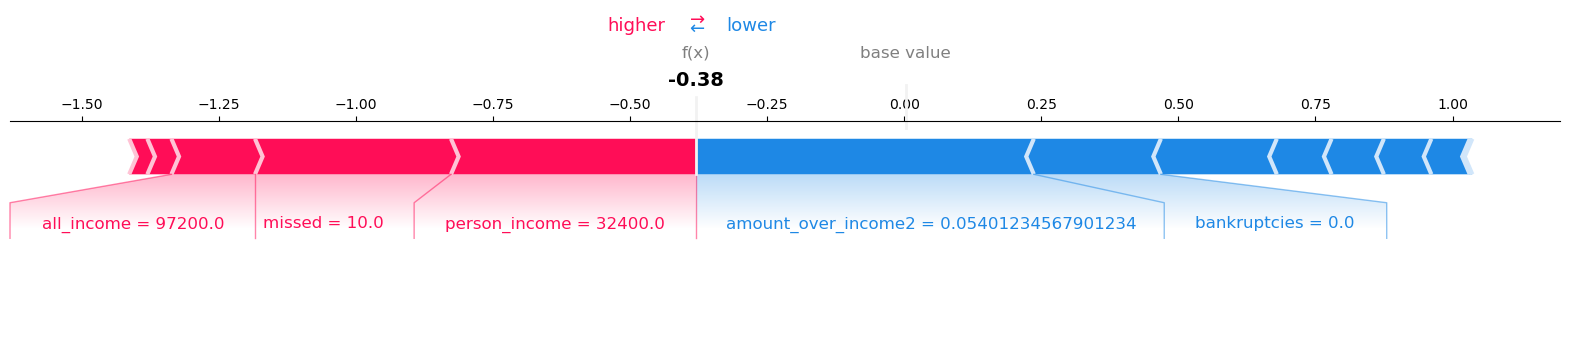

In [42]:
idx = 3
print(y_sample_prob[idx])
pprint(json.loads(X_sample.iloc[idx,:].to_json()))
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_sample.iloc[idx,:],
    matplotlib=True
)

[0.5461912  0.45380878]
{'all_income': 84000.0,
 'amount_over_all': -2.0511899811,
 'amount_over_income2': 0.2571428571,
 'bankruptcies': 0.0,
 'hard_pulls': 5.0,
 'loan_amnt': 10800.0,
 'loan_int_rate': 13.99,
 'loan_intent': 4.0,
 'missed': 7.0,
 'mortgage_due': 1746590.0,
 'person_home_ownership': 3.0,
 'person_income': 42000.0,
 'real_age': 43.0}


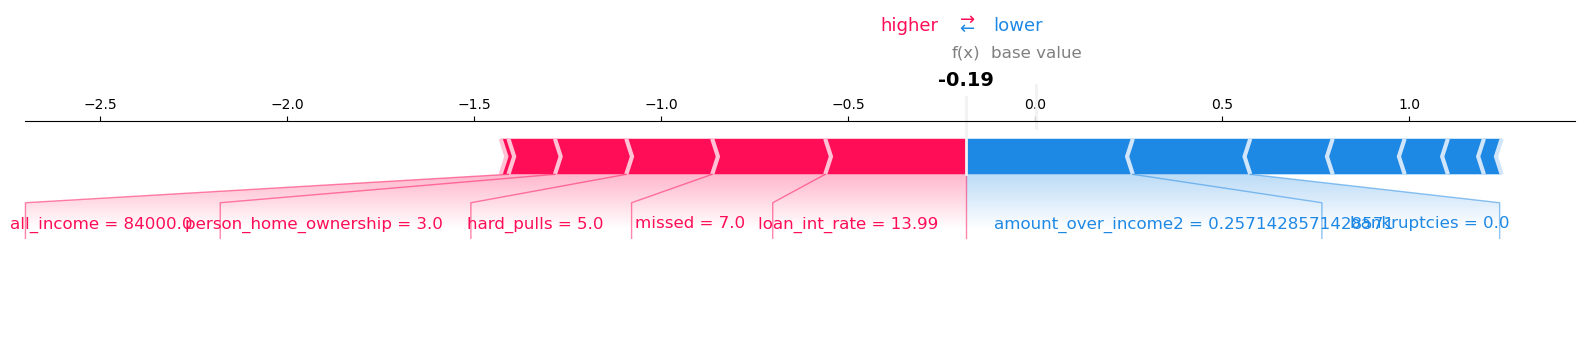

In [43]:
idx = 4
print(y_sample_prob[idx])
pprint(json.loads(X_sample.iloc[idx,:].to_json()))
shap.force_plot(
    explainer.expected_value,
    shap_values[idx,:],
    X_sample.iloc[idx,:],
    matplotlib=True
)

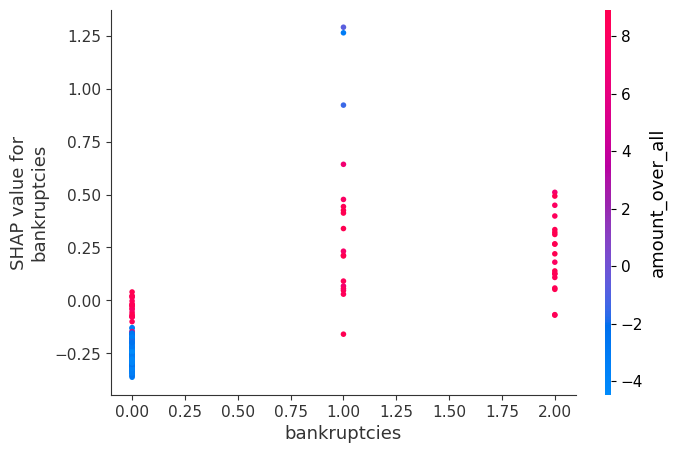

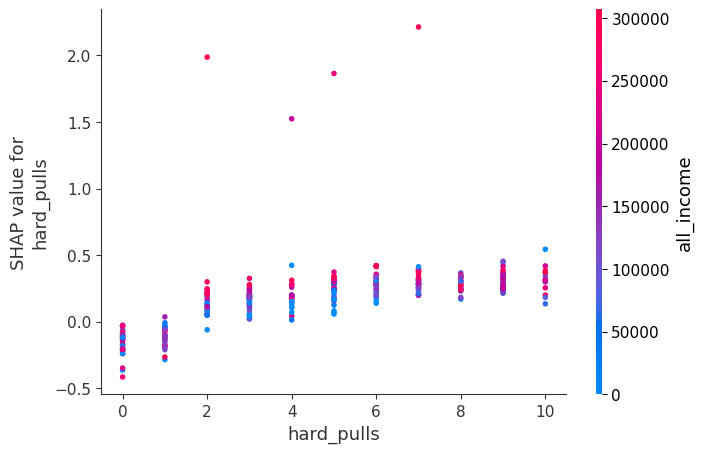

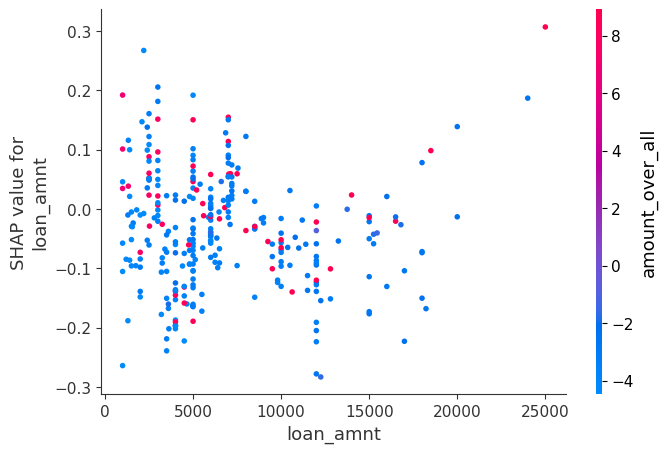

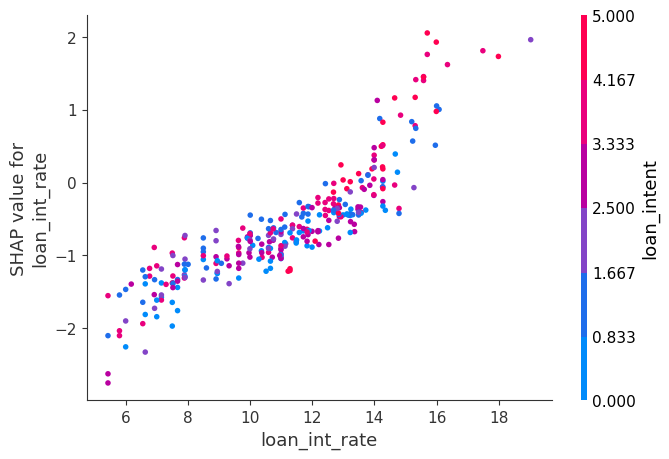

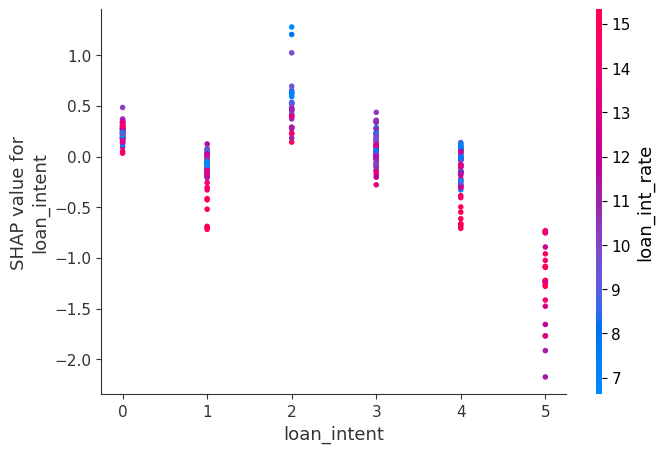

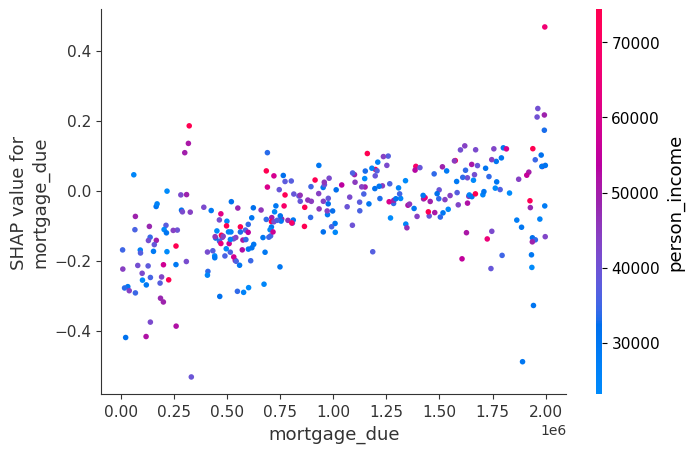

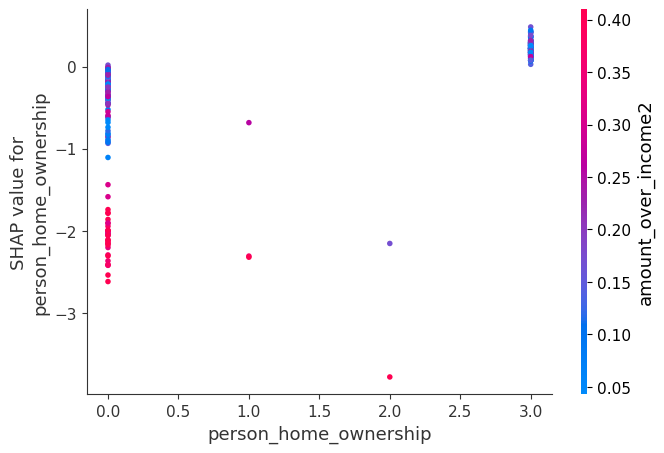

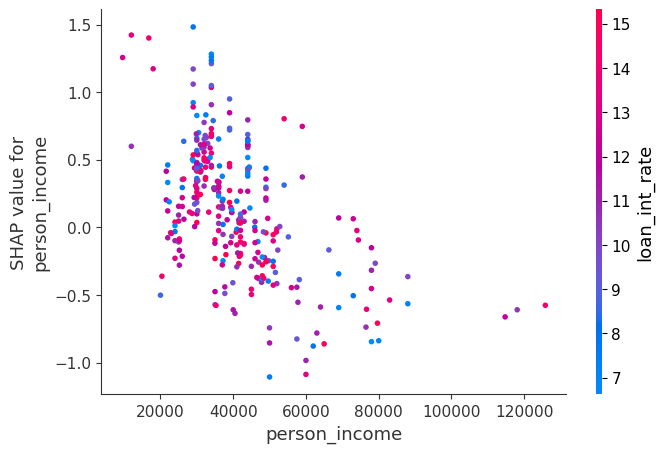

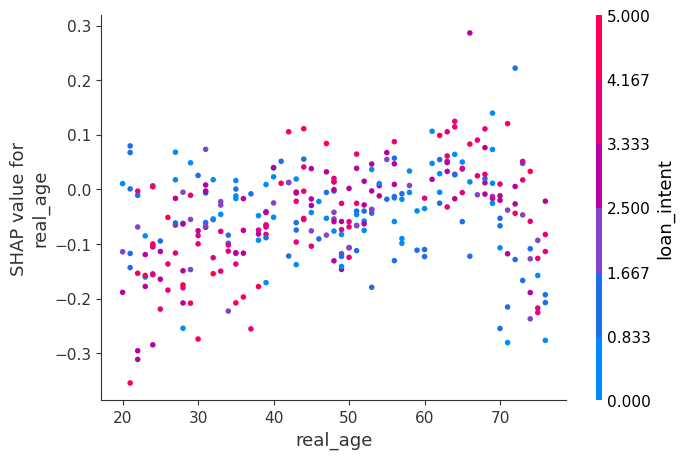

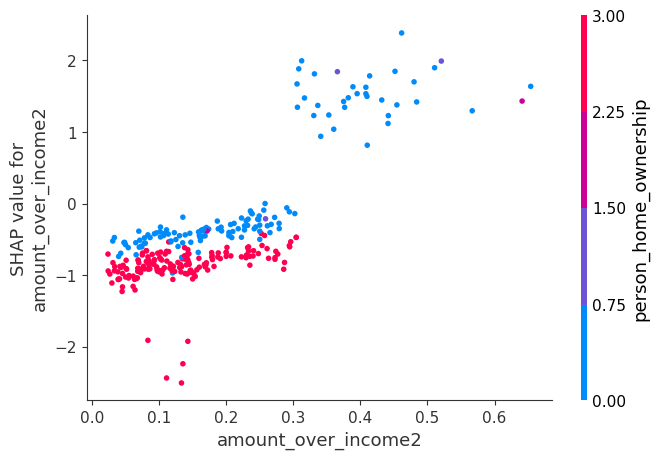

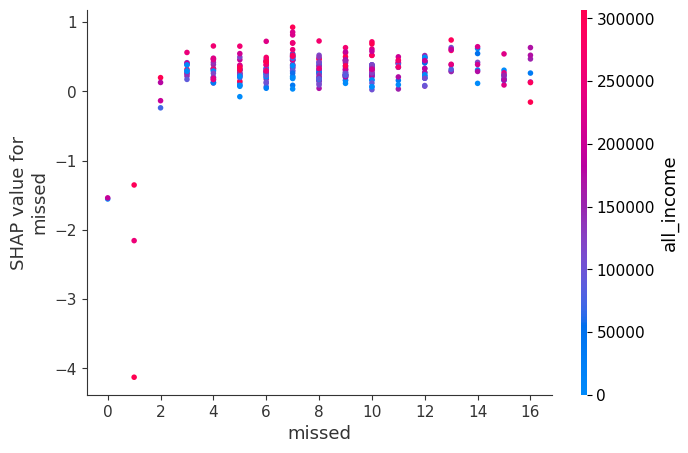

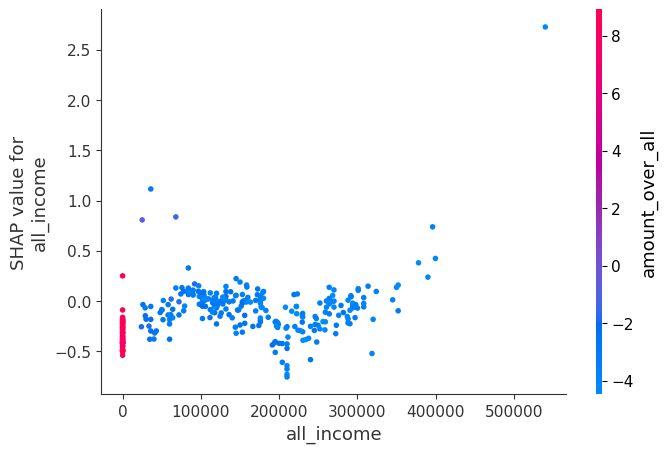

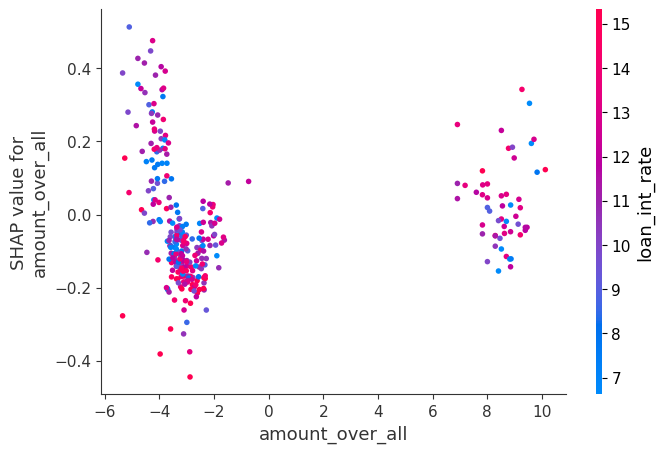

In [44]:
for c in X_sample.columns:
    shap.dependence_plot(c, shap_values, X_sample)

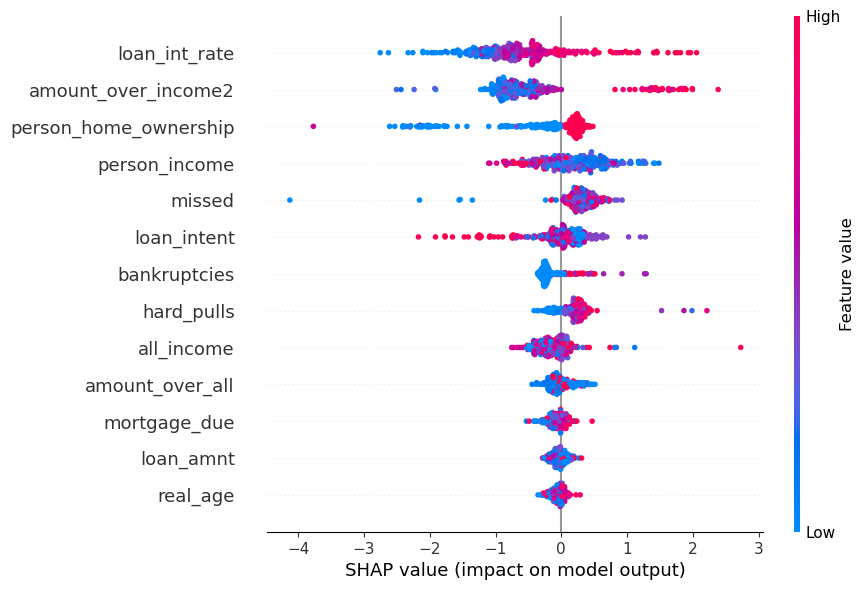

In [45]:
shap.summary_plot(shap_values, X_sample) 

In [ ]:
# sss

In [ ]:
# !pip install shap==0.38.1

In [ ]:
# !pip install matplotlib==3.2.2